##### Copyright 2024 Google LLC.

### Install the client library

In [7]:
!pip install -q google-generativeai

### Import libraries

In [8]:
import google.generativeai as genai

In [9]:
from google.colab import userdata
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

You can check you existing tuned models with the `genai.list_tuned_model` method.

In [10]:
for i, m in zip(range(5), genai.list_tuned_models()):
  print(m.name)

tunedModels/generate-num-4913
tunedModels/generate-num-5302
tunedModels/generate-num-5849
tunedModels/polio-awareness-tuned-model-4751
tunedModels/polio-awareness-tuned-model-5428


## Create tuned model

To create a tuned model, you need to pass your dataset to the model in the `genai.create_tuned_model` method. You can do this be directly defining the input and output values in the call or importing from a file into a dataframe to pass to the method.

For this example, you will tune a model to generate the next number in the sequence. For example, if the input is `1`, the model should output `2`. If the input is `one hundred`, the output should be `one hundred one`.

In [11]:
base_model = [
    m for m in genai.list_models()
    if "createTunedModel" in m.supported_generation_methods and
    "flash" in m.name][0]
base_model

Model(name='models/gemini-1.5-flash-001-tuning',
      base_model_id='',
      version='001',
      display_name='Gemini 1.5 Flash 001 Tuning',
      description=('Version of Gemini 1.5 Flash that supports tuning, our fast and versatile '
                   'multimodal model for scaling across diverse tasks, released in May of 2024.'),
      input_token_limit=16384,
      output_token_limit=8192,
      supported_generation_methods=['generateContent', 'countTokens', 'createTunedModel'],
      temperature=1.0,
      max_temperature=2.0,
      top_p=0.95,
      top_k=64)

In [13]:
import json
import random

# Load training data from a JSON file
with open('polio_dataset.json', 'r') as file:
    training_data = json.load(file)

# Generate a unique model name
name = f'generate-num-{random.randint(0, 10000)}'

# Create tuned model
operation = genai.create_tuned_model(
    source_model=base_model.name,
    training_data=training_data,
    id=name,
    epoch_count=100,
    batch_size=4,
    learning_rate=0.001,
)


Your tuned model is immediately added to the list of tuned models, but its status is set to "creating" while the model is tuned.

In [14]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model

TunedModel(name='tunedModels/generate-num-6443',
           source_model='models/gemini-1.5-flash-001-tuning',
           base_model='models/gemini-1.5-flash-001-tuning',
           display_name='',
           description='',
           temperature=1.0,
           top_p=0.95,
           top_k=64,
           state=<State.CREATING: 1>,
           create_time=datetime.datetime(2025, 5, 19, 18, 19, 42, 520637, tzinfo=datetime.timezone.utc),
           update_time=datetime.datetime(2025, 5, 19, 18, 19, 42, 520637, tzinfo=datetime.timezone.utc),
           tuning_task=TuningTask(start_time=None,
                                  complete_time=None,
                                  snapshots=[],
                                  hyperparameters=Hyperparameters(epoch_count=100,
                                                                  batch_size=4,
                                                                  learning_rate=0.001)),
           reader_project_numbers=None)

In [15]:
model.state

<State.CREATING: 1>

### Check tuning progress

Use `metadata` to check the state:

In [16]:
operation.metadata

total_steps: 1375
tuned_model: "tunedModels/generate-num-6443"

Wait for the training to finish using `operation.result()`, or `operation.wait_bar()`

In [17]:
import time

for status in operation.wait_bar():
  time.sleep(30)

  0%|          | 0/1375 [00:00<?, ?it/s]

You can cancel your tuning job any time using the `cancel()` method. Uncomment the line below and run the code cell to cancel your job before it finishes.

In [18]:
# operation.cancel()

Once the tuning is complete, you can view the loss curve from the tuning results. The [loss curve](https://ai.google.dev/gemini-api/docs/model-tuning#recommended_configurations) shows how much the model's predictions deviate from the ideal outputs.

<Axes: xlabel='epoch', ylabel='mean_loss'>

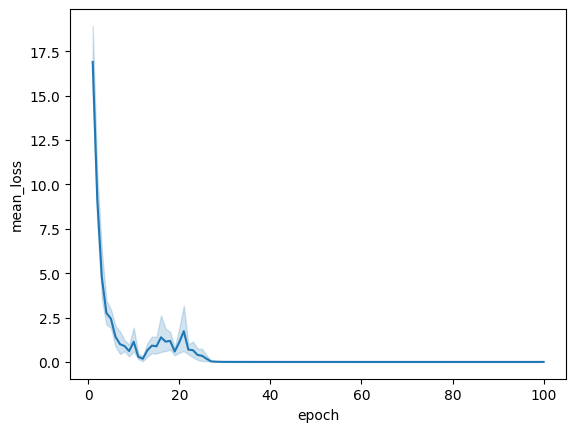

In [19]:
import pandas as pd
import seaborn as sns

model = operation.result()

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')


## Evaluate your model

You can use the `genai.generate_content` method and specify the name of your model to test your model performance.

In [24]:
model = genai.GenerativeModel(model_name=f'tunedModels/{name}')

In [32]:
result = model.generate_content('የፖሊዮ እና የመተላለፊያ መንገዶች ምን እንደሆኑ በዝርዝር?')
result.text

'ፖሊዮ በፖሊዮቫይረስ የሚተላለፍ ተላላፊ በሽታ ነው። በተለምልሞ የተበከለ ውሃ ወይም የምግብ እቃዎችን በመጠቀም ይተላለፋል። በአንዳንድ አገሮች በሰዎች ከሰው ወደ ሰው በቀጥታ እንደሚተላለፍም ይታወቃል።'

In [34]:
result = model.generate_content('poliyoon maal akka ta’ee fi karaalee daddarbiinsa bal’inaa natihimmii?')
result.text

'Odoo, poliyoon maal akka ta’ee fi karaalee daddarbiinsa bal’inaa natihimmii. Poliyoon vaayraasiin uumamuun daddarbii akka taakiisee ilaalchisee bal’inaa natihimmaa.'

In [30]:
result = model.generate_content('what is polio?')
result.text

'Polio is a contagious disease caused by the poliovirus. It primarily affects children and can lead to permanent paralysis. However, polio is preventable with vaccines. Thanks to vaccination efforts, polio has been eradicated in many parts of the world.'

It really seems to have picked up the task despite the limited examples, but "next" is a simple concept, see the [tuning guide](https://ai.google.dev/gemini-api/docs/model-tuning) for more guidance on improving performance.

## Update the description

You can update the description of your tuned model any time using the `genai.update_tuned_model` method.

In [ ]:
genai.update_tuned_model(f'tunedModels/{name}', {"description":"This is my model."});

In [ ]:
model = genai.get_tuned_model(f'tunedModels/{name}')

model.description

'This is my model.'

## Delete the model

You can clean up your tuned model list by deleting models you no longer need. Use the `genai.delete_tuned_model` method to delete a model. If you canceled any tuning jobs, you may want to delete those as their performance may be unpredictable.

In [ ]:
genai.delete_tuned_model(f'tunedModels/{name}')

The model no longer exists:

In [ ]:
try:
  m = genai.get_tuned_model(f'tunedModels/{name}')
  print(m)
except Exception as e:
  print(f"{type(e)}: {e}")

<class 'google.api_core.exceptions.NotFound'>: 404 GET https://generativelanguage.googleapis.com/v1beta/tunedModels/generate-num-8122?%24alt=json%3Benum-encoding%3Dint: Tuned model tunedModels/generate-num-8122 does not exist.
